In [55]:
import numpy as np
import pandas as pd
from lstm_functions import *
from lost_functions import *
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import yfinance as yf

# Reading and storing the Data

In [2]:
xls = pd.ExcelFile('data/data_for_testing.xlsx')
all_data = {}
# This is too much data to load into memory at once
# for sheet in xls.sheet_names:
#     all_data[sheet] = pd.read_excel(xls, sheet_name=sheet)
for sheet in ["XOM", "SHW", "UPS", "DUK", "UNH", "JPM", "AMZN", "AAPL", "META", "AMT"]:
    data = pd.read_excel(xls, sheet_name=sheet).set_index('Date')
    # Resample to monthly data as a simple way to reduce the number of data points
    # Daily data is too much and take too long to train
    monthly_data = data.resample('M').last().reset_index()
    all_data[sheet] = monthly_data

In [3]:
all_data['XOM'].head()

,Date,Open,High,Low,Close,Adj Close,Volume,Sector,Ticker
0,1962-01-31,0.0,1.656250,1.636719,1.656250,0.101445,1718400,Energy,XOM
1,1962-02-28,0.0,1.757813,1.726563,1.730469,0.107163,2131200,Energy,XOM
2,1962-03-31,0.0,1.710938,1.703125,1.707031,0.105711,809600,Energy,XOM
3,1962-04-30,0.0,1.710938,1.671875,1.671875,0.103534,1222400,Energy,XOM
4,1962-05-31,0.0,1.632813,1.609375,1.625000,0.101744,3190400,Energy,XOM


In [4]:
all_data["AAPL"].columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Sector',
       'Ticker'],
      dtype='object')

In [5]:
final_importance_values = {}
final_predictions = {}
# 30 is not a good number of batches, but it's a start for testing
# 60 is a good number of batches, but it takes a long time to train
time_steps = 30
features = 6

In [ ]:
# Loop through each stock data
for ticker, data in all_data.items():
    
    # Drop non-numeric columns
    data = data.drop(columns=['Sector', 'Ticker', 'Date'])  # Assuming 'Date' is the index
    lstm_model = LstmBuilder(time_step=time_steps, loss=huber_loss)
    model = lstm_model.create_model(features=features)
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    X, y = lstm_model.create_sequences(normalized_data)
    X_train, X_test, y_train, y_test = lstm_model.split_data(X,y)
    
    print("Working on: " + ticker)  
    model.fit(X_train, y_train, epochs=3, batch_size=4, validation_split=0.2, verbose=0)
    '''
    Batch Size: Refers to the number of training examples utilized in one iteration. When you set batch_size=32, it means the model takes 32 sequences at a time and updates weights once after computing the loss of the entire batch.
    Input Shape (60, 6): Refers to the shape of a single input sequence.
    60 indicates the number of time steps in each sequence. In your case, each sequence contains data from 60 days.
    6 refers to the number of features ('Open', 'High', 'Low', 'Close', 'Adj Close', and 'Volume').
    So, when you train your LSTM, it takes in 32 sequences (if we consider batch_size=32) at a time, and each of those sequences contains 60 time steps with 6 features for each time step.

    In simpler terms:

    Input Shape: Shape of a single sequence that you feed into the model.
    Batch Size: Number of sequences you feed into the model at one go.
    These two are different parameters and have different roles in the training process. The batch size is related to how you update the weights during training, whereas the input shape is related to the structure and size of your input data.
    '''
    
    # Predict the next day value
    last_days = normalized_data[-time_steps:].reshape(1, time_steps, features)
    prediction_next_day = model.predict(last_days)
    prediction_next_day_actual = scaler.inverse_transform(prediction_next_day)
    final_predictions[ticker] = prediction_next_day_actual.flatten()
    print(f"Predicted value for {ticker}: {prediction_next_day_actual.flatten()}")

    
    # Extracting importance
    dense_weights = model.layers[-1].get_weights()[0]

    # Think about to use sum or mean and to use abs() or not
    feature_weights = dense_weights.sum(axis=0)
    weighted_importance = prediction_next_day.flatten() * feature_weights
    final_importance_value = np.sum(weighted_importance)  # Final importance as a single value
    print(f"Importance value for {ticker}: {final_importance_value}")
    
    # Store the importance value in the dictionary
    final_importance_values[ticker] = final_importance_value

print(final_importance_values)

In [13]:
final_importance_values

{'XOM': -24.02027,
 'SHW': 5.5614214,
 'UPS': 5.2308617,
 'DUK': -5.3437276,
 'UNH': 0.14171359,
 'JPM': 8.934374,
 'AMZN': 2.0873442,
 'AAPL': 0.16826911,
 'META': 1.3775032,
 'AMT': -2.9676592}

In [44]:
importance_values = np.array(list(final_importance_values.values()))

# Run this if we want a arbitrage strategy
Each weight will be -1 to 1, the sum is 0

In [45]:
# 1. Scale the values to [-1, 1]
arbitrage_scaled_importance = 2 * (importance_values - np.min(importance_values)) / (np.max(importance_values) - np.min(importance_values)) - 1

# 2. Ensure the sum is zero
arbitrage_normalized_importance = arbitrage_scaled_importance - np.mean(arbitrage_scaled_importance)

# Convert back to dictionary
arbitrage_ticker_to_importance = dict(zip(final_importance_values.keys(), arbitrage_normalized_importance))

print(arbitrage_ticker_to_importance)

{'XOM': -1.4041877, 'SHW': 0.39110965, 'UPS': 0.37104803, 'DUK': -0.27071816, 'UNH': 0.062190354, 'JPM': 0.59581226, 'AMZN': 0.18026954, 'AAPL': 0.063801944, 'META': 0.13718969, 'AMT': -0.1265158}


# Run this instead if we want a normal strategy
Each weight will be 0 to 1, the sum is 1

In [46]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))  # subtract max to avoid potential overflow
    return e_x / e_x.sum(axis=0)

# Convert the importance values to probabilities using softmax
probabilities = softmax(importance_values)

# Convert back to dictionary
normalized_ticker_to_importance = dict(zip(final_importance_values.keys(), probabilities))

print(normalized_ticker_to_importance)

{'XOM': 4.595538e-15, 'SHW': 0.03232224, 'UPS': 0.02322422, 'DUK': 5.9354767e-07, 'UNH': 0.00014313703, 'JPM': 0.9426621, 'AMZN': 0.0010016797, 'AAPL': 0.00014698911, 'META': 0.0004925484, 'AMT': 6.3880584e-06}


In [47]:
def plot_importance(normalized_ticker_to_importance = normalized_ticker_to_importance, title='Normalized Importance Values'):
# Split the tickers and importance values based on positive and negative values
    long_positions = {k: v for k, v in normalized_ticker_to_importance.items() if v > 0}
    short_positions = {k: v for k, v in normalized_ticker_to_importance.items() if v <= 0}

    # Sort the positions for better visualization
    sorted_long = dict(sorted(long_positions.items(), key=lambda item: item[1], reverse=True))
    sorted_short = dict(sorted(short_positions.items(), key=lambda item: item[1]))

    # Create bar charts
    fig, ax = plt.subplots(figsize=(12, 7))

    # Positive cluster
    bars_long = ax.bar(sorted_long.keys(), sorted_long.values(), color='g', label='Long')

    # Negative cluster
    bars_short = ax.bar(sorted_short.keys(), sorted_short.values(), color='r', label='Short')

    # Rotate x-tick labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Annotate the bars
    for bar in bars_long:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom', fontsize=9)

    for bar in bars_short:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval - 0.02, round(yval, 3), ha='center', va='top', fontsize=9)

    ax.set_title(title)
    ax.set_ylabel('Importance Value')
    ax.set_xlabel('Ticker')
    ax.legend()

    plt.tight_layout()
    plt.show()


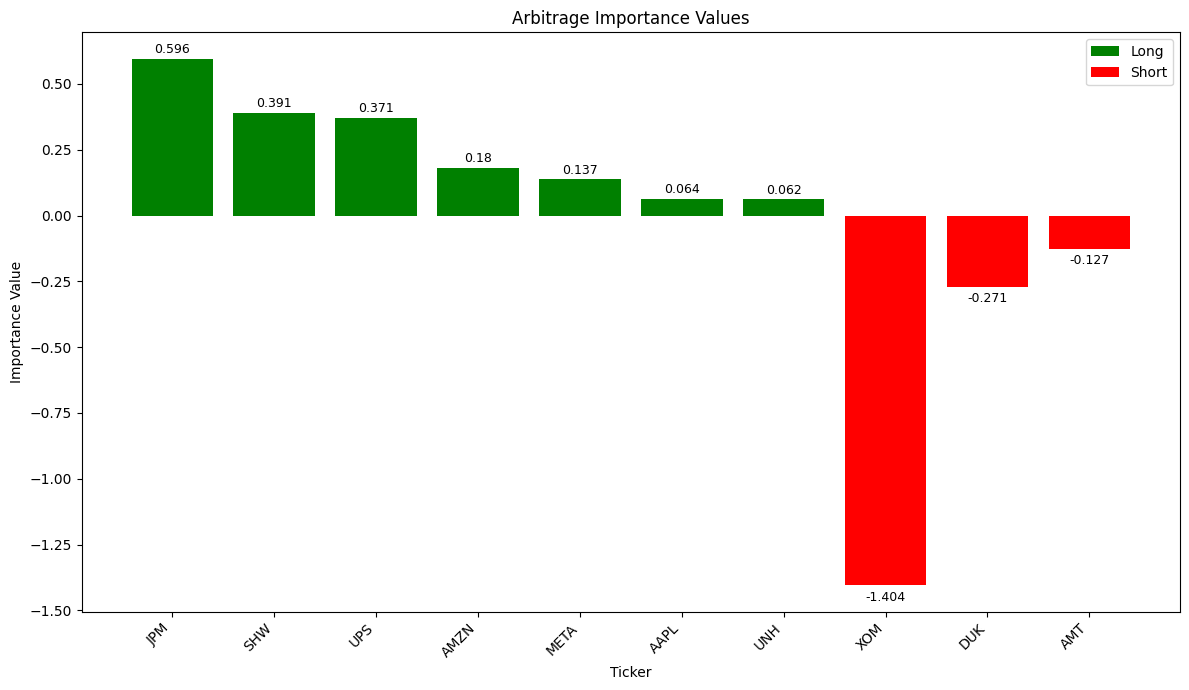

In [48]:
# Plot the arbitrage importance values
plot_importance(arbitrage_ticker_to_importance, title='Arbitrage Importance Values')

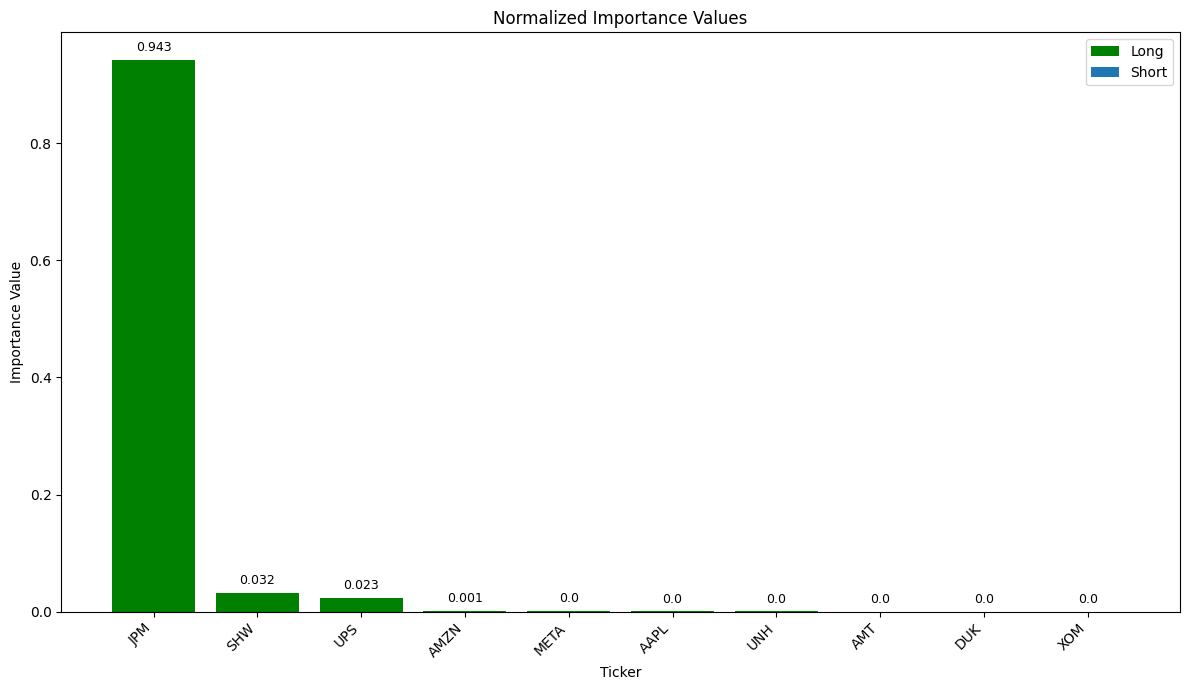

In [49]:
# Plot the importance values
plot_importance(normalized_ticker_to_importance, title='Normalized Importance Values')

In [32]:
spy_data = yf.download('SPY')
spy_monthly = spy_data.resample('M').last()
spy_monthly

[*********************100%%**********************]  1 of 1 completed


,Open,High,...,Adj Close,Volume
Date,,,,,
1993-01-31,43.968750,43.968750,...,24.941395,1003200
1993-02-28,44.437500,44.437500,...,25.207489,66200
1993-03-31,45.343750,45.468750,...,25.772102,111600
1993-04-30,44.125000,44.281250,...,25.112648,88500
1993-05-31,45.406250,45.406250,...,25.789946,79100
...,...,...,...,...,...
2023-05-31,418.279999,419.220001,...,414.840332,110811800
2023-06-30,441.440002,444.299988,...,441.721893,104921500
2023-07-31,457.410004,458.160004,...,456.180908,62040400


In [33]:
all_data

{'XOM':           Date        Open  ...  Sector  Ticker
 0   1962-01-31    0.000000  ...  Energy     XOM
 1   1962-02-28    0.000000  ...  Energy     XOM
 2   1962-03-31    0.000000  ...  Energy     XOM
 3   1962-04-30    0.000000  ...  Energy     XOM
 4   1962-05-31    0.000000  ...  Energy     XOM
 ..         ...         ...  ...     ...     ...
 736 2023-05-31  102.290001  ...  Energy     XOM
 737 2023-06-30  107.320000  ...  Energy     XOM
 738 2023-07-31  105.190002  ...  Energy     XOM
 739 2023-08-31  111.120003  ...  Energy     XOM
 740 2023-09-30  117.550003  ...  Energy     XOM
 
 [741 rows x 9 columns],
 'SHW':           Date        Open  ...     Sector  Ticker
 0   1980-03-31    0.000000  ...  Materials     SHW
 1   1980-04-30    0.000000  ...  Materials     SHW
 2   1980-05-31    0.000000  ...  Materials     SHW
 3   1980-06-30    0.000000  ...  Materials     SHW
 4   1980-07-31    0.000000  ...  Materials     SHW
 ..         ...         ...  ...        ...     ...
 518 20

In [51]:
# Construct the Portfolio and Backtest
def build_portfolio(normalized_ticker_to_importance=normalized_ticker_to_importance, strategy='Normal'):
    portfolio_returns = pd.DataFrame()
    for ticker, importance in normalized_ticker_to_importance.items():
        data = all_data[ticker].set_index('Date')
        data['Returns'] = data['Adj Close'].pct_change().fillna(0)
        portfolio_returns[ticker] = data['Returns'] * importance
    portfolio_returns['Portfolio'] = portfolio_returns.sum(axis=1)
    spy_monthly['SPY Returns'] = spy_monthly['Adj Close'].pct_change().fillna(0)
    # Cumulative Returns
    portfolio_returns['Cumulative Portfolio'] = (portfolio_returns['Portfolio'] + 1).cumprod() - 1
    spy_monthly['Cumulative SPY'] = (spy_monthly['SPY Returns'] + 1).cumprod() - 1
    combined = pd.concat([portfolio_returns['Cumulative Portfolio'], spy_monthly['Cumulative SPY']], axis=1).dropna()
    print(combined)
    # Plot
    plt.figure(figsize=(14,7))
    combined['Cumulative Portfolio'].plot(label="Portfolio")
    combined['Cumulative SPY'].plot(label="SPY")
    plt.legend()
    plt.title(strategy + " Portfolio vs. SPY Cumulative Returns")
    plt.show()


            Cumulative Portfolio  Cumulative SPY
Date                                            
1993-01-31             -0.992259        0.000000
1993-02-28             -0.992964        0.010669
1993-03-31             -0.993273        0.033306
1993-04-30             -0.993537        0.006866
1993-05-31             -0.993566        0.034022
...                          ...             ...
2023-05-31             -0.988667       15.632604
2023-06-30             -0.987674       16.710393
2023-07-31             -0.986406       17.290112
2023-08-31             -0.988293       16.992861
2023-09-30             -0.989570       16.827191

[369 rows x 2 columns]


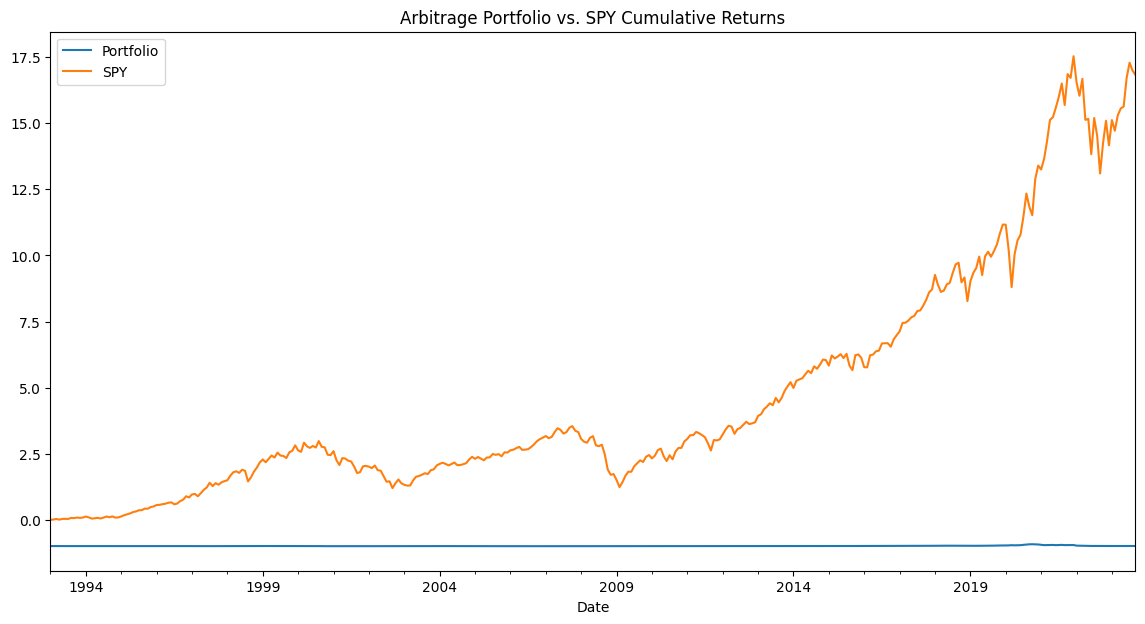

In [53]:
# Build the portfolio for arbitrage strategy
build_portfolio(arbitrage_ticker_to_importance, strategy='Arbitrage')

            Cumulative Portfolio  Cumulative SPY
Date                                            
1993-01-31              4.170809        0.000000
1993-02-28              4.167075        0.010669
1993-03-31              4.194334        0.033306
1993-04-30              3.930977        0.006866
1993-05-31              3.940744        0.034022
...                          ...             ...
2023-05-31            136.002065       15.632604
2023-06-30            146.247137       16.710393
2023-07-31            159.591522       17.290112
2023-08-31            148.041704       16.992861
2023-09-30            150.686342       16.827191

[369 rows x 2 columns]


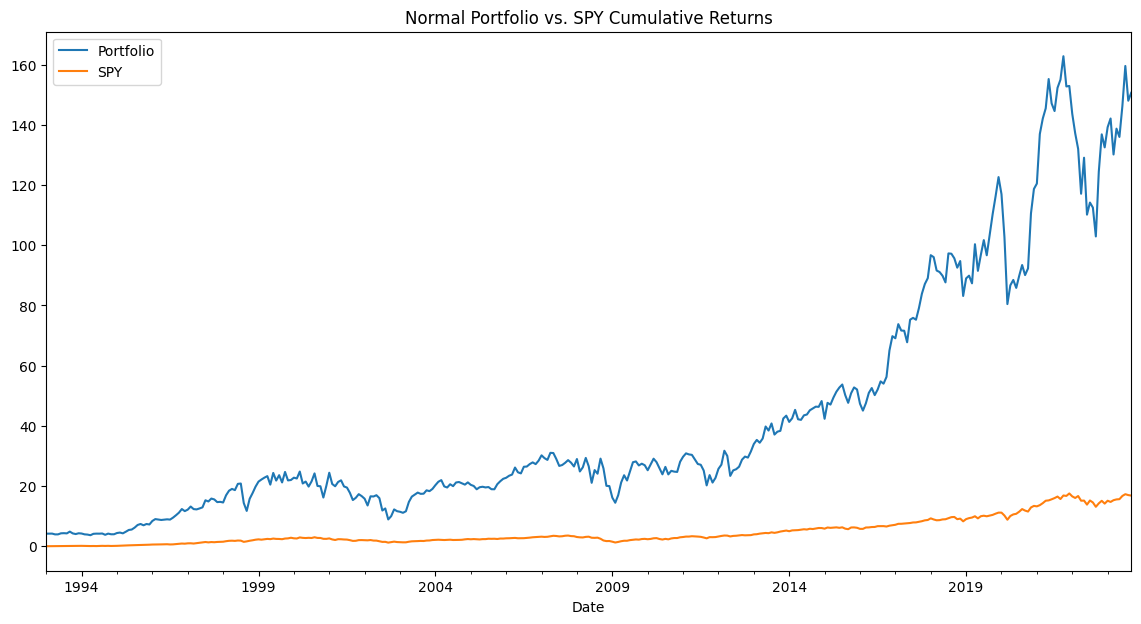

In [52]:
# Build the portfolio for the Normal strategy
build_portfolio(normalized_ticker_to_importance, strategy='Normal')